In [1]:
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from contextlib import contextmanager
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import missingno

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
# from functions import read_table_from_pg, write_table_to_pg

In [2]:
from contextlib import contextmanager


@contextmanager
def get_time():
    """
    Генератор для измерения времени выполнения кода внутри блока `with`.
    """
    try:
        start_time = datetime.now()
        print(f"Started at: {start_time}")
        yield
    finally:
        end_time = datetime.now()
        print(f"Ended at: {end_time}")
        print(f"Duration: {end_time - start_time}", end="\n\n")


def read_table_from_pg(
        spark,
        table_name,
        username="maxglnv",
        password = "MaxVika100415",
        host="rc1b-diwt576i60sxiqt8.mdb.yandexcloud.net",
        port="6432",
        database="hse_db"
):
    """
    Загружает таблицу из PostgreSQL в Spark DataFrame.

    Параметры:
    spark (SparkSession): Сессия Spark, используемая для выполнения операций.
    table_name (str): Имя таблицы, которую необходимо загрузить из базы данных.

    Возвращает:
    pyspark.sql.DataFrame: Spark DataFrame, содержащий данные из указанной таблицы базы данных.
    """
    with get_time():
        db_url = f"jdbc:postgresql://{host}:{port}/{database}"
        try:
            df_table = spark.read \
                .format("jdbc") \
                .option("url", db_url) \
                .option("driver", "org.postgresql.Driver") \
                .option("dbtable", table_name) \
                .option("user", username) \
                .option("password", password) \
                .load()
            
            print(f"Данные успешно загружены из таблицы {table_name} PostgreSQL в Spark DataFrame.")
            return df_table
        
        except Exception as e:
            raise Exception(f"Произошла ошибка при чтении таблицы {table_name} из базы данных: {e}") from e
    

def write_table_to_pg(
        df,
        spark,
        write_mode,
        table_name,
        username="maxglnv",
        password = "MaxVika100415",
        host="rc1b-diwt576i60sxiqt8.mdb.yandexcloud.net",
        port="6432",
        database="hse_db"
):
    """
    Записывает данные из Spark DataFrame в таблицу PostgreSQL.

    Параметры:
    df (pyspark.sql.DataFrame): DataFrame, который будет записан в базу данных.
    spark (SparkSession): Сессия Spark, используемая для выполнения операций.
    write_mode (str): Режим записи (например, 'append', 'overwrite', 'ignore', 'error').
    table_name (str): Имя целевой таблицы в базе данных, куда будут записаны данные.
    username (str): Имя пользователя для подключения к базе данных.
    password (str): Пароль пользователя.
    host (str): Хост, на котором расположена база данных.
    port (str): Порт для подключения к базе данных.
    database (str): Имя базы данных.
    """
    with get_time():
        db_url = f"jdbc:postgresql://{host}:{port}/{database}"
        df.cache() 
        print("Количество строк:", df.count())

        try:
            df.write \
                .mode(write_mode) \
                .format("jdbc") \
                .option("url", db_url) \
                .option("driver", "org.postgresql.Driver") \
                .option("dbtable", table_name) \
                .option("user", username) \
                .option("password", password) \
                .save()
            print(f"Spark DataFrame успешно записан в PostgreSQL в таблицу {table_name}.")
        except Exception as e:
            raise Exception(f"Произошла ошибка при записи таблицы {table_name} в базу данных: {e}") from e

        print("Количество строк:", df.count())
        df.unpersist()

In [3]:
spark = (
    SparkSession.builder.config(
        "spark.jars",
        "/System/Volumes/Data/Users/shiryaevva/Library/Python/3.9/lib/python/site-packages/pyspark/jars/postgresql-42.3.1.jar",
    )
    .master("local[*]")
    .appName("parse_teams")
    .getOrCreate()
)

24/05/06 21:14:31 WARN Utils: Your hostname, MacBookPro14.local resolves to a loopback address: 127.0.0.1; using 192.168.5.16 instead (on interface en0)
24/05/06 21:14:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/05/06 21:14:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df_games = read_table_from_pg(spark, "public.games_wide_datamart")
teams_stat = read_table_from_pg(spark, "public.teams_stat_wide_datamart")
nhl_games_odds = read_table_from_pg(spark, "public.nhl_games_odds")

Started at: 2024-05-06 21:14:32.735006
Данные успешно загружены из таблицы public.games_wide_datamart PostgreSQL в Spark DataFrame.
Ended at: 2024-05-06 21:14:35.401400
Duration: 0:00:02.666394

Started at: 2024-05-06 21:14:35.401506
Данные успешно загружены из таблицы public.teams_stat_wide_datamart PostgreSQL в Spark DataFrame.
Ended at: 2024-05-06 21:14:36.720922
Duration: 0:00:01.319416

Started at: 2024-05-06 21:14:36.721031
Данные успешно загружены из таблицы public.nhl_games_odds PostgreSQL в Spark DataFrame.
Ended at: 2024-05-06 21:14:38.027678
Duration: 0:00:01.306647



In [5]:
df_games = df_games.toPandas()
teams_stat = teams_stat.toPandas()
nhl_games_odds = nhl_games_odds.toPandas()

24/05/06 21:14:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


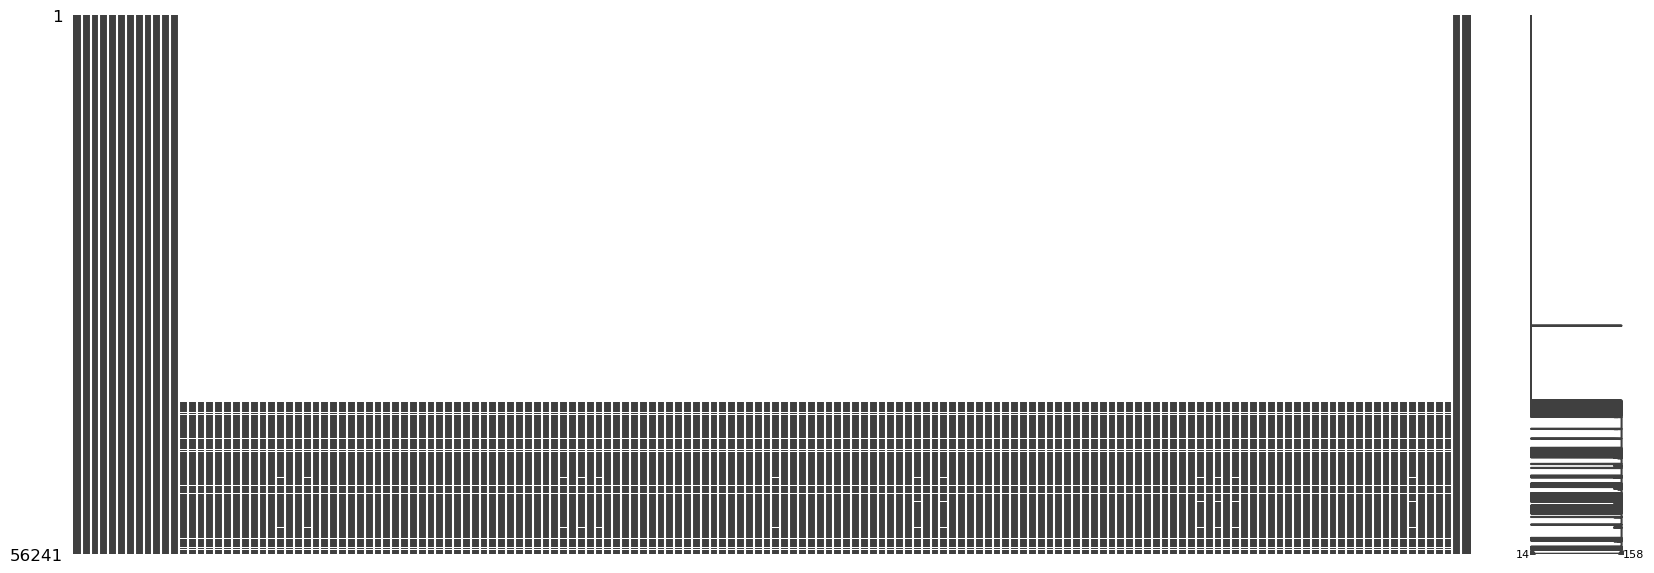

In [6]:
missingno.matrix(df_games, figsize=(20, 7), label_rotation=45, fontsize=10);

In [7]:
df_games = df_games.sort_values('eastern_start_time')

df_games['game_date'] = df_games.game_date.astype(str)

df_games['home_team_name'] = df_games['home_team_name'].replace('Phoenix Coyotes', 'Arizona Coyotes')
df_games['visiting_team_name'] = df_games['visiting_team_name'].replace('Phoenix Coyotes', 'Arizona Coyotes')

df_games['home_team_code'] = df_games['home_team_code'].replace('PHI', 'ARI')
df_games['visiting_team_code'] = df_games['visiting_team_code'].replace('PHI', 'ARI')

df_games.head()

,game_source_id,game_date,eastern_start_time,season,home_team_code,home_team_name,visiting_team_code,visiting_team_name,game_type,home_score,...,v_ties,v_waivers_sequence,v_wildcard_sequence,v_win_pctg,v_wins,v_team_name,v_conference_name,v_division_name,home_team_winner,game_month
8,1924020009,1924-12-08,1924-12-08T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,3,...,NaN,NaN,NaN,NaN,NaN,None,None,None,0,12
12,1924020023,1924-12-25,1924-12-25T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,NaN,NaN,NaN,NaN,NaN,None,None,None,1,12
15,1924020039,1925-01-10,1925-01-10T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,2,...,NaN,NaN,NaN,NaN,NaN,None,None,None,0,1
19,1924020052,1925-01-27,1925-01-27T20:15:00,19241925,BOS,Boston Bruins,MTL,Montréal Canadiens,2,0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,0,1
21,1924020069,1925-02-14,1925-02-14T20:30:00,19241925,MTL,Montréal Canadiens,BOS,Boston Bruins,2,5,...,NaN,NaN,NaN,NaN,NaN,None,None,None,1,2


In [8]:
def fill_na_by_team(group):
    return group.fillna(method='ffill').fillna(method='bfill')


columns_to_fill = sorted(df_games.columns[df_games.isna().any()].tolist())

df_games[columns_to_fill[:72]] = df_games.groupby('home_team_code')[columns_to_fill[:72]].transform(fill_na_by_team)
df_games[columns_to_fill[72:]] = df_games.groupby('visiting_team_code')[columns_to_fill[72:]].transform(fill_na_by_team)

In [9]:
df_games = df_games[df_games.season >= 20112012]

df_games['h_avg_home_goals_for'] = df_games['h_home_goals_for'] / df_games['h_home_games_played']
df_games['v_avg_road_goals_against'] = df_games['v_road_goals_against'] / df_games['v_road_games_played']

df_games['v_avg_road_goals_for'] = df_games['v_road_goals_for'] / df_games['v_road_games_played']
df_games['h_avg_home_goals_against'] = df_games['h_home_goals_against'] / df_games['h_home_games_played']

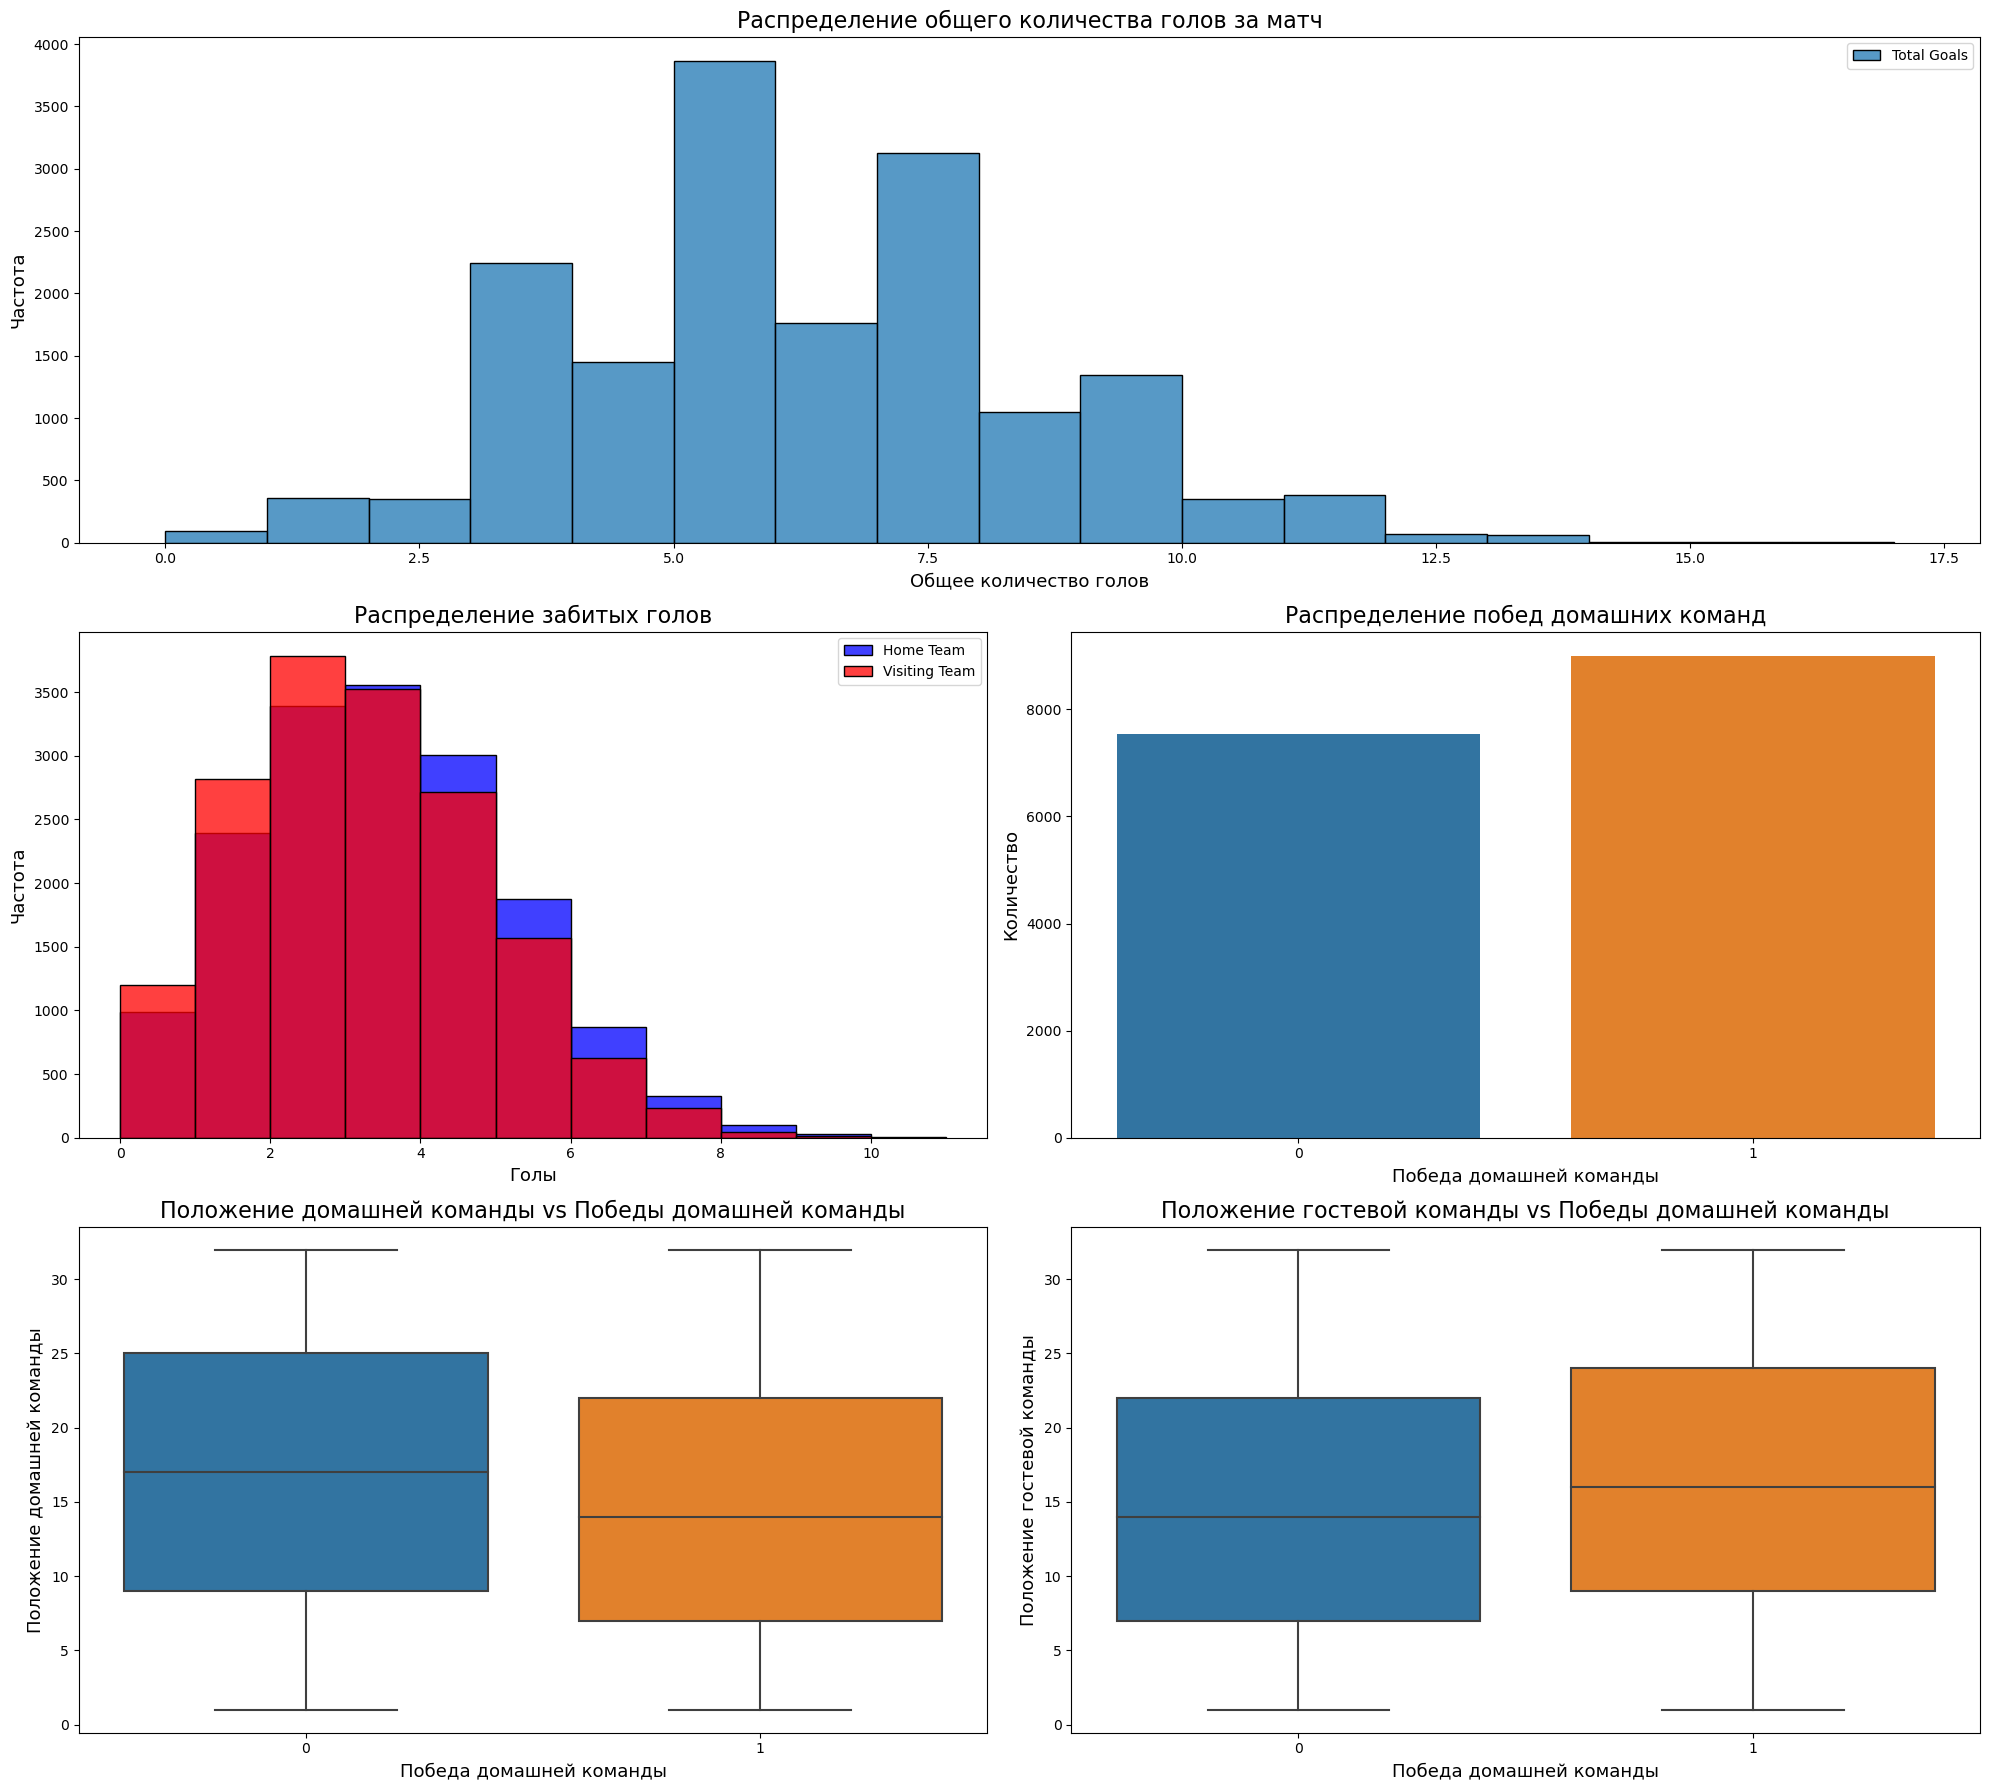

In [10]:
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[0, :])
df_games['total_goals'] = df_games['home_score'] + df_games['visiting_score']
sns.histplot(data=df_games, x='total_goals', bins=range(df_games['total_goals'].max() + 1), 
             label='Total Goals', ax=ax0)
ax0.set_title('Распределение общего количества голов за матч', fontsize=16)
ax0.set_xlabel('Общее количество голов', fontsize=13)
ax0.set_ylabel('Частота', fontsize=13)
ax0.legend()

ax1 = plt.subplot(gs[1, 0])
sns.histplot(data=df_games, x='home_score', bins=11, color='blue', label='Home Team', ax=ax1)
sns.histplot(data=df_games, x='visiting_score', bins=10, color='red', label='Visiting Team', ax=ax1)
ax1.set_title('Распределение забитых голов', fontsize=16)
ax1.set_xlabel('Голы', fontsize=13)
ax1.set_ylabel('Частота', fontsize=13)
ax1.legend()

ax2 = plt.subplot(gs[1, 1])
sns.countplot(data=df_games, x='home_team_winner', ax=ax2)
ax2.set_title('Распределение побед домашних команд', fontsize=16)
ax2.set_xlabel('Победа домашней команды', fontsize=13)
ax2.set_ylabel('Количество', fontsize=13)

ax3 = plt.subplot(gs[2, 0])
sns.boxplot(data=df_games, x='home_team_winner', y='h_league_sequence', ax=ax3)
ax3.set_title('Положение домашней команды vs Победы домашней команды', fontsize=16)
ax3.set_xlabel('Победа домашней команды', fontsize=13)
ax3.set_ylabel('Положение домашней команды', fontsize=13)

ax4 = plt.subplot(gs[2, 1])
sns.boxplot(data=df_games, x='home_team_winner', y='v_league_sequence', ax=ax4)
ax4.set_title('Положение гостевой команды vs Победы домашней команды', fontsize=16)
ax4.set_xlabel('Победа домашней команды', fontsize=13)
ax4.set_ylabel('Положение гостевой команды', fontsize=13)

plt.tight_layout()
plt.show()

**Выводы:**
* Большинство игр заканчивается с количеством голов в диапазоне от 4 до 7. 
* Данные показывают, что домашние команды (синий цвет) забивают голы чаще, чем гостевые команды (красный цвет), что может указывать на домашнее преимущество.
* Явно видна тенденция домашних команд к победе в матчах 
* Распределение показывает, что положение команды в лиге не имеет явного влияния на исход матча (победы или поражения домашней команды). Размах и медиана величины h_conference_home_sequence схожи как для побед, так и для поражений.
* Похоже, что также нет сильной зависимости между положением гостевой команды в своей конференции и исходом игры для домашней команды.

In [11]:
fig = go.Figure()

teams_stat = teams_stat.sort_values('date')

selected_season = 20212022
default_teams = ['BOS', 'SJS', 'CAR', 'CGY']
all_teams = sorted(teams_stat['team_business_id'].unique())

for team in all_teams:
    team_data = teams_stat[(teams_stat['season_id'] >= selected_season) & (teams_stat['team_business_id'] == team)]
    fig.add_trace(go.Scatter(
        x=team_data['date'],
        y=team_data['win_pctg'],
        name=team,
        visible='legendonly' if team not in default_teams else True
    ))

fig.update_layout(
    title='Изменение процента побед команд',
    xaxis_title='Дата игры',
    yaxis_title='Процент побед',
    width=1300,
    height=600
)

fig.show()


In [12]:
games_merged = (
    pd.merge(
        df_games,
        nhl_games_odds,
        on=["home_team_name", "game_date", "visiting_team_name"],
        how="inner",
    )
    .sort_values(by="game_date")
    .fillna(0)
)
games_merged.drop(columns=["eastern_dt"], inplace=True)

games_merged.tail()

,game_source_id,game_date,eastern_start_time,season,home_team_code,home_team_name,visiting_team_code,visiting_team_name,game_type,home_score,...,home_team_winner,game_month,h_avg_home_goals_for,v_avg_road_goals_against,v_avg_road_goals_for,h_avg_home_goals_against,total_goals,win_home_team,draw,win_visiting_team
16423,2023030125,2024-04-30,2024-04-30T19:00:00,20232024,BOS,Boston Bruins,TOR,Toronto Maple Leafs,3,1,...,0,4,3.425,2.900,3.575,2.700,3,1.97,4.14,3.19
16426,2023030175,2024-04-30,2024-04-30T22:00:00,20232024,VAN,Vancouver Canucks,NSH,Nashville Predators,3,1,...,0,4,3.500,2.950,3.300,2.450,3,2.24,4.07,2.70
16428,2023030185,2024-05-01,2024-05-01T22:00:00,20232024,EDM,Edmonton Oilers,LAK,Los Angeles Kings,3,4,...,1,5,4.025,2.700,3.050,2.600,7,1.81,4.38,3.54
16427,2023030155,2024-05-01,2024-05-01T19:30:00,20232024,DAL,Dallas Stars,VGK,Vegas Golden Knights,3,3,...,1,5,3.825,3.400,3.200,3.075,5,2.03,4.20,3.03
16429,2023030126,2024-05-02,2024-05-02T20:00:00,20232024,TOR,Toronto Maple Leafs,BOS,Boston Bruins,3,2,...,1,5,3.800,2.775,3.225,3.400,3,2.67,4.11,2.25


## Разделим данные на train и test

In [13]:
games_merged = games_merged.sort_values(by="game_date").drop(
    columns=[
        "game_source_id",
        "eastern_start_time",
        "game_date",
        "game_type",
        "score_delta",
        "home_team_name",
        "visiting_team_name",
        "home_score",
        "visiting_score",
        "total_goals",
        "v_team_name",
        "h_team_name",
    ]
)

test_index = int(0.06 * len(games_merged))

df_train = games_merged.iloc[:-test_index]
df_test = games_merged.iloc[-test_index:]

X_train = df_train.drop(columns=["home_team_winner"])
y_train = df_train.home_team_winner

X_test = df_test.drop(columns=["home_team_winner"])
y_test = df_test.home_team_winner

X_train.tail()

,season,home_team_code,visiting_team_code,h_conference_home_sequence,h_conference_l10_sequence,h_conference_road_sequence,h_conference_sequence,h_division_home_sequence,h_division_l10_sequence,h_division_road_sequence,...,v_conference_name,v_division_name,game_month,h_avg_home_goals_for,v_avg_road_goals_against,v_avg_road_goals_for,h_avg_home_goals_against,win_home_team,draw,win_visiting_team
15440,20232024,PIT,ARI,15.0,9.0,5.0,11.0,8.0,5.0,2.0,...,Eastern,Metropolitan,12,2.636364,2.454545,3.090909,2.454545,1.93,4.39,3.19
15442,20232024,ARI,STL,7.0,9.0,8.0,8.0,5.0,6.0,4.0,...,Western,Central,12,3.700000,3.166667,2.583333,3.100000,2.27,4.28,2.59
15443,20232024,ANA,COL,15.0,16.0,11.0,14.0,8.0,8.0,6.0,...,Western,Central,12,2.692308,3.083333,3.166667,3.230769,3.86,4.70,1.71
15445,20232024,VGK,WSH,2.0,10.0,3.0,1.0,2.0,4.0,2.0,...,Eastern,Metropolitan,12,3.454545,2.875000,3.125000,1.818182,1.87,4.37,3.42
15441,20232024,OTT,SEA,11.0,15.0,16.0,16.0,6.0,7.0,8.0,...,Western,Pacific,12,3.384615,3.384615,2.692308,3.538462,2.27,4.36,2.60


In [14]:
categorical_features = [
    "season",
    "home_team_code",
    "visiting_team_code",
    "h_conference_name",
    "h_division_name",
    "h_streak_code",
    "v_conference_name",
    "v_division_name",
    "v_streak_code",
    "game_month"
]

numeric_features = X_train.drop(columns=categorical_features).select_dtypes(include=['int64', 'float64']).columns.tolist()

## Обучим модель предсказывать какая команды победит
#### Домашняя команда - 1, команда на выезде - 0

### LogisticRegression

In [28]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_lg = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=5000, random_state=17))])

pipeline_lg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['h_conference_home_sequence',
                                                   'h_conference_l10_sequence',
                                                   'h_conference_road_sequence',
                                                   'h_conference_sequence',
                                                   'h_division_home_sequence',
                                                   'h_division_l10_sequence',
                                                   'h_division_road_sequence',
                                                   'h_division_sequence',
                                                   'h_game_type_id',
                                                   'h_games_played',
                                                   'h_goal_differe...
                                                   'h_l10_goal_differential',
                                                   'h_l10_goals_against',
                                                   'h_l10_goals_for', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_conference_name',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_conference_name',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier',
                 LogisticRegression(max_iter=5000, random_state=17))])

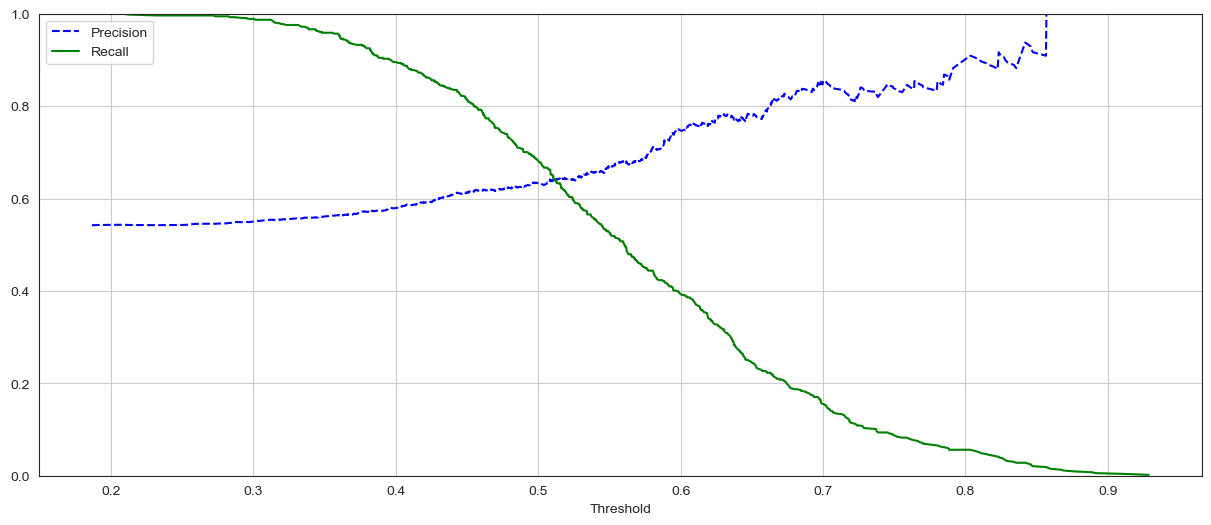

In [77]:
y_proba_lg = pipeline_lg.predict_proba(X_test)
y_proba_win_lg = y_proba_lg[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_lg)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.grid()
plt.show()

Precision: 0.669047619047619
Recall: 0.5262172284644194


<AxesSubplot:>

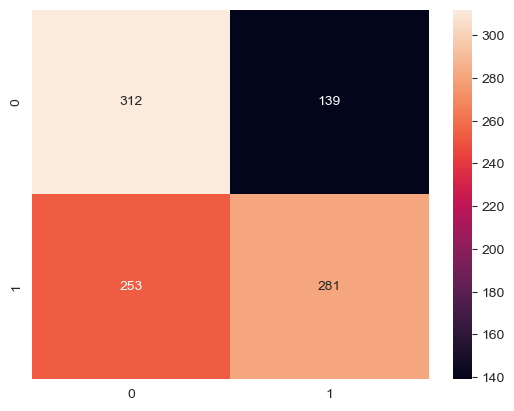

In [78]:
threshold = 0.55

y_pred = np.where(y_proba_win_lg >= threshold, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [79]:
score_dict = {'model': [], 'precision': [], 'recall': [], 'threshold': []}

score_dict['model'].append('LogisticRegression')
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['threshold'].append(threshold)

### SVM

In [42]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=17))
])

pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['h_conference_home_sequence',
                                                   'h_conference_l10_sequence',
                                                   'h_conference_road_sequence',
                                                   'h_conference_sequence',
                                                   'h_division_home_sequence',
                                                   'h_division_l10_sequence',
                                                   'h_division_road_sequence',
                                                   'h_division_sequence',
                                                   'h_game_type_id',
                                                   'h_games_played',
                                                   'h_goal_differe...
                                                   'h_l10_goal_differential',
                                                   'h_l10_goals_against',
                                                   'h_l10_goals_for', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_conference_name',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_conference_name',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier', SVC(probability=True, random_state=17))])

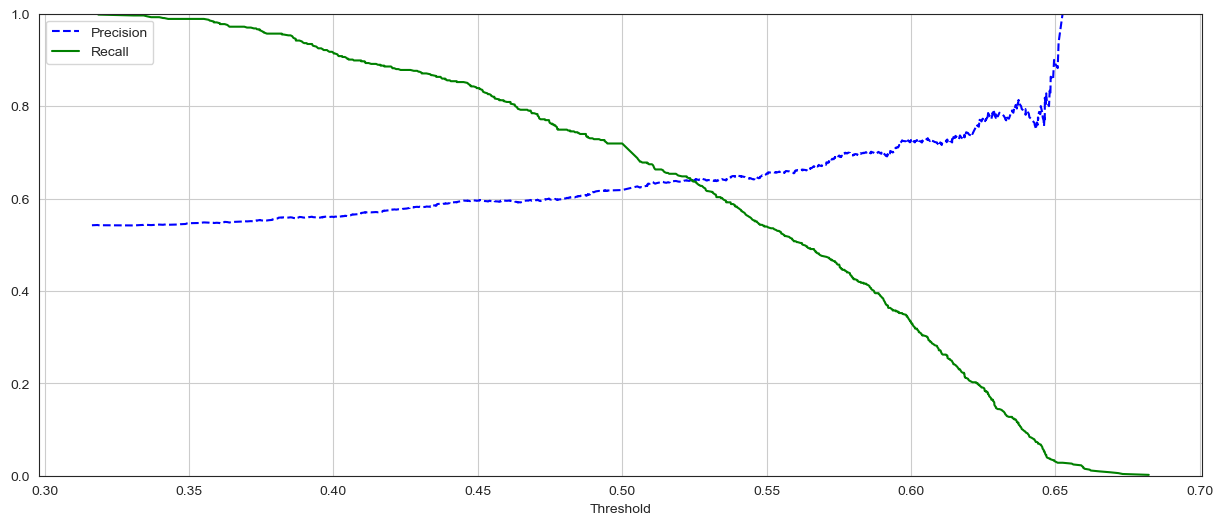

In [80]:
y_proba_svc = pipeline_svc.predict_proba(X_test)
y_proba_win_svc = y_proba_svc[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_svc)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

Precision: 0.6545454545454545
Recall: 0.5393258426966292


<AxesSubplot:>

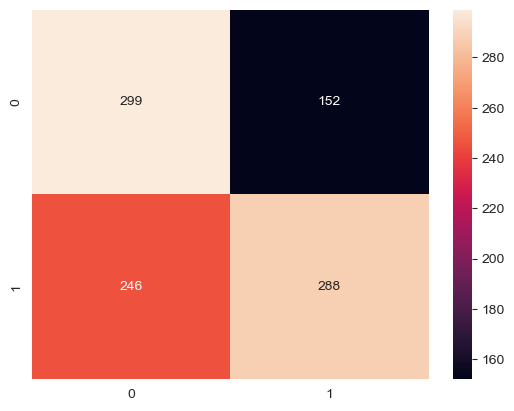

In [81]:
threshold = 0.55

y_pred = np.where(y_proba_win_svc >= threshold, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [82]:
score_dict['model'].append('SVC')
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['threshold'].append(threshold)

### CatBoostClassifier

In [47]:
catboost_cl = CatBoostClassifier(
    iterations=10000,
    random_state=17,
    cat_features=categorical_features,
)

catboost_cl.fit(X_train, y_train, verbose=500)

Learning rate set to 0.004014
0:	learn: 0.6929456	total: 76.3ms	remaining: 12m 43s
500:	learn: 0.6622490	total: 7.03s	remaining: 2m 13s
1000:	learn: 0.6537451	total: 14s	remaining: 2m 5s
1500:	learn: 0.6467524	total: 20.9s	remaining: 1m 58s
2000:	learn: 0.6401997	total: 27.9s	remaining: 1m 51s
2500:	learn: 0.6330491	total: 34.8s	remaining: 1m 44s
3000:	learn: 0.6241124	total: 41.9s	remaining: 1m 37s
3500:	learn: 0.6151311	total: 49s	remaining: 1m 30s
4000:	learn: 0.6065084	total: 56s	remaining: 1m 23s
4500:	learn: 0.5983492	total: 1m 3s	remaining: 1m 17s
5000:	learn: 0.5905542	total: 1m 10s	remaining: 1m 10s
5500:	learn: 0.5830470	total: 1m 17s	remaining: 1m 3s
6000:	learn: 0.5757059	total: 1m 24s	remaining: 56.1s
6500:	learn: 0.5685752	total: 1m 31s	remaining: 49.1s
7000:	learn: 0.5616068	total: 1m 38s	remaining: 42.1s
7500:	learn: 0.5544274	total: 1m 45s	remaining: 35.1s
8000:	learn: 0.5476928	total: 1m 52s	remaining: 28.1s
8500:	learn: 0.5411905	total: 1m 59s	remaining: 21.1s
9000:	

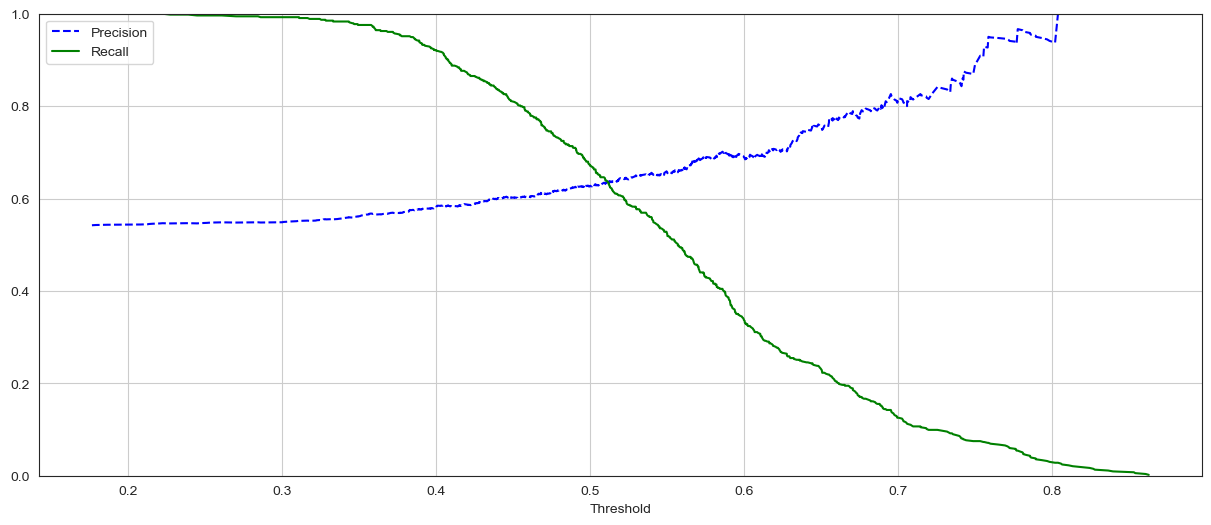

In [83]:
y_proba_catboost = catboost_cl.predict_proba(X_test)
y_proba_win_catboost = y_proba_catboost[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_catboost)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.grid()
plt.show()

Precision: 0.6572769953051644
Recall: 0.5243445692883895


<AxesSubplot:>

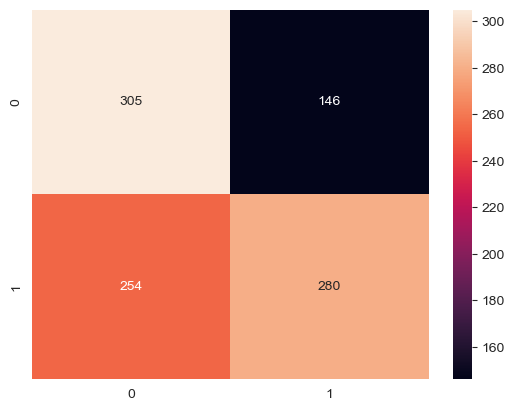

In [84]:
threshold = 0.55

y_pred = np.where(y_proba_win_catboost >= threshold, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [85]:
score_dict['model'].append('CatBoostClassifier')
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['threshold'].append(threshold)

In [51]:
def plot_feature_importance(model, X, size=(20, 30)):
    model_importances = pd.DataFrame(model.feature_importances_, columns=['feature_importance'], index=X.columns)
    
    fig = plt.figure(figsize = size)
    sns.set_style('white')
    ax = sns.barplot(x='feature_importance', 
                y=model_importances.index, 
                data=model_importances, 
                order=model_importances.sort_values(by='feature_importance', ascending=False).index);

    for rect in ax.patches:
        ax.text(rect.get_width() + 0.001, rect.get_y() + rect.get_height() / 2, 
                round(rect.get_width(), 3), verticalalignment='center', fontsize = 11)

    plt.xlabel('Feature importance', fontsize=16);
    plt.ylabel('Feature', fontsize=16);
    
    return model_importances

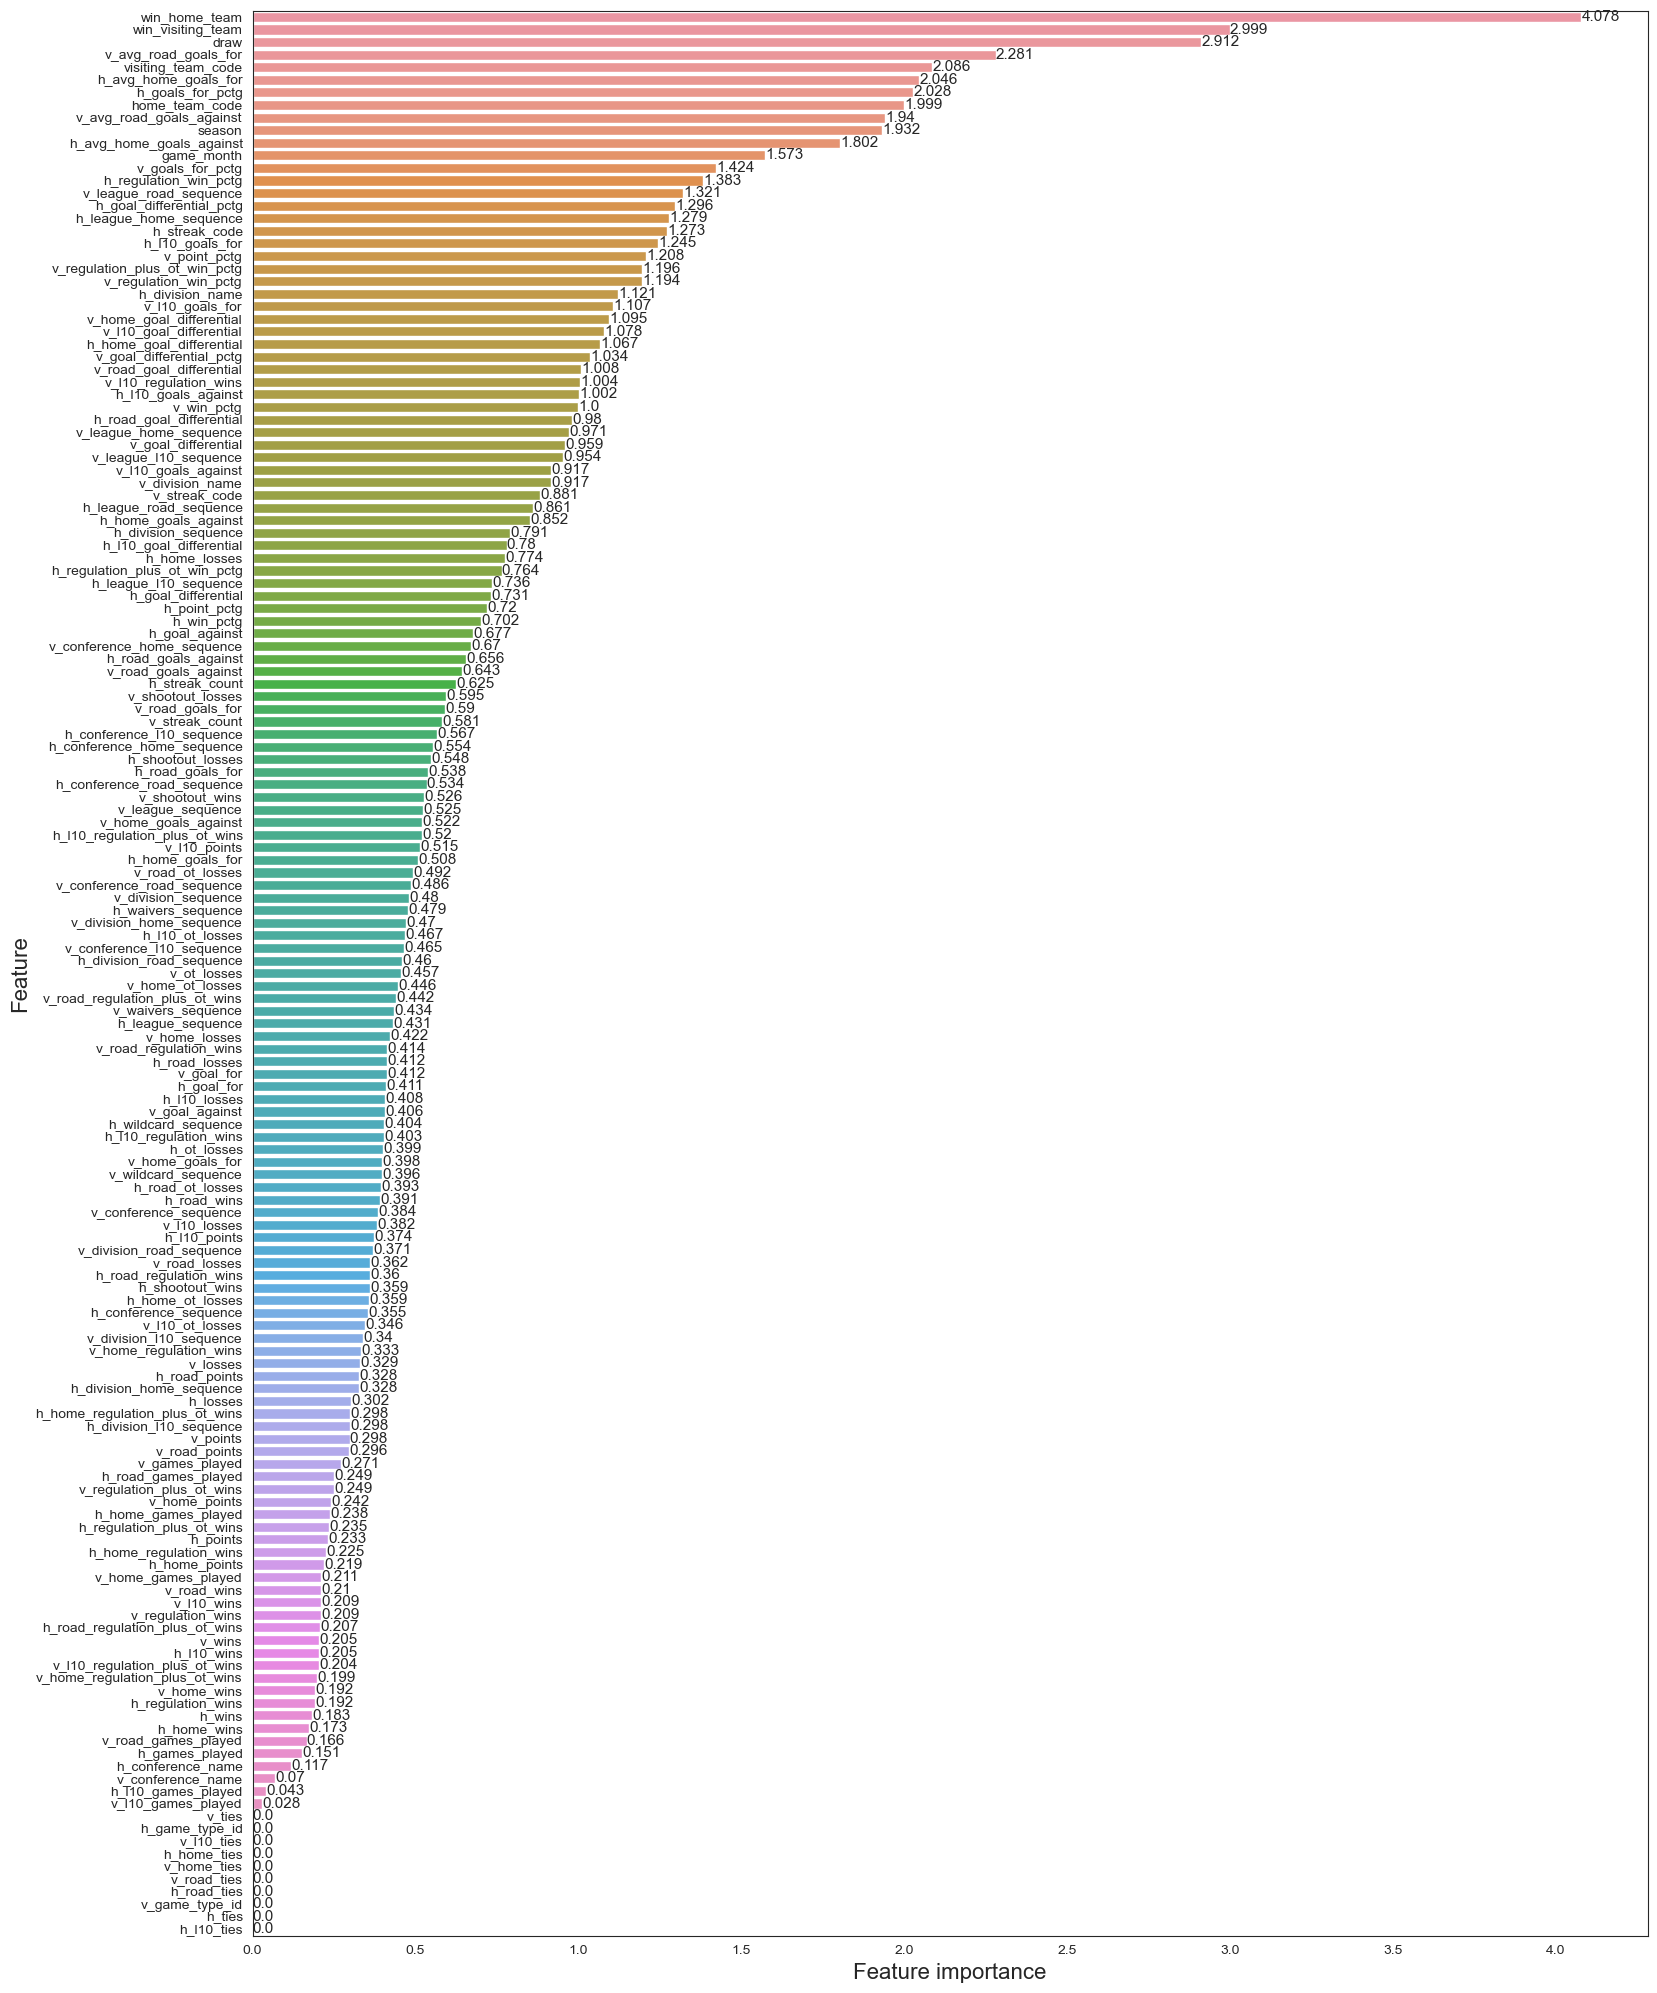

In [52]:
catboost_cl_importance = plot_feature_importance(catboost_cl, X_train, (18, 25))

## Отберем признаки

In [54]:
top_features = list(catboost_cl_importance.sort_values('feature_importance', ascending=False).reset_index().rename(columns={'index': 'feature'}).head(80).feature)

In [55]:
X_train_top = df_train[top_features]
X_test_top = df_test[top_features]

X_train_top.tail()

,win_home_team,win_visiting_team,draw,v_avg_road_goals_for,visiting_team_code,h_avg_home_goals_for,h_goals_for_pctg,home_team_code,v_avg_road_goals_against,season,...,v_division_sequence,h_waivers_sequence,v_division_home_sequence,h_l10_ot_losses,v_conference_l10_sequence,h_division_road_sequence,v_ot_losses,v_home_ot_losses,v_road_regulation_plus_ot_wins,v_waivers_sequence
15440,1.93,3.19,4.39,3.090909,ARI,2.636364,3.136364,PIT,2.454545,20232024,...,5.0,16.0,7.0,1.0,6.0,2.0,2.0,1.0,5.0,14.0
15442,2.27,2.59,4.28,2.583333,STL,3.700000,3.272727,ARI,3.166667,20232024,...,4.0,18.0,3.0,1.0,6.0,4.0,1.0,0.0,5.0,19.0
15443,3.86,1.71,4.70,3.166667,COL,2.692308,2.739130,ANA,3.083333,20232024,...,1.0,3.0,1.0,0.0,2.0,6.0,1.0,0.0,6.0,28.0
15445,1.87,3.42,4.37,3.125000,WSH,3.454545,3.250000,VGK,2.875000,20232024,...,3.0,29.0,2.0,3.0,2.0,2.0,2.0,1.0,5.0,25.0
15441,2.27,2.60,4.36,2.692308,SEA,3.384615,3.444444,OTT,3.384615,20232024,...,5.0,7.0,7.0,0.0,13.0,8.0,6.0,1.0,4.0,8.0


In [56]:
categorical_features = [
    "season",
    "home_team_code",
    "visiting_team_code",
    # "h_conference_name",
    "h_division_name",
    "h_streak_code",
    # "v_conference_name",
    "v_division_name",
    "v_streak_code",
    "game_month"
]

numeric_features = X_train_top.drop(columns=categorical_features).select_dtypes(include=['int64', 'float64']).columns.tolist()

### LogisticRegression

In [58]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipeline_lg_top = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=5000, random_state=17)),
    ]
)

pipeline_lg_top.fit(X_train_top, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['win_home_team',
                                                   'win_visiting_team', 'draw',
                                                   'v_avg_road_goals_for',
                                                   'h_avg_home_goals_for',
                                                   'h_goals_for_pctg',
                                                   'v_avg_road_goals_against',
                                                   'h_avg_home_goals_against',
                                                   'v_goals_for_pctg',
                                                   'h_regulation_win_pctg',
                                                   'v_league_road_sequence',
                                                   'h_goal_differential_pctg',
                                                   'h_l...
                                                   'h_road_goal_differential',
                                                   'v_league_home_sequence',
                                                   'v_goal_differential',
                                                   'v_league_l10_sequence', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier',
                 LogisticRegression(max_iter=5000, random_state=17))])

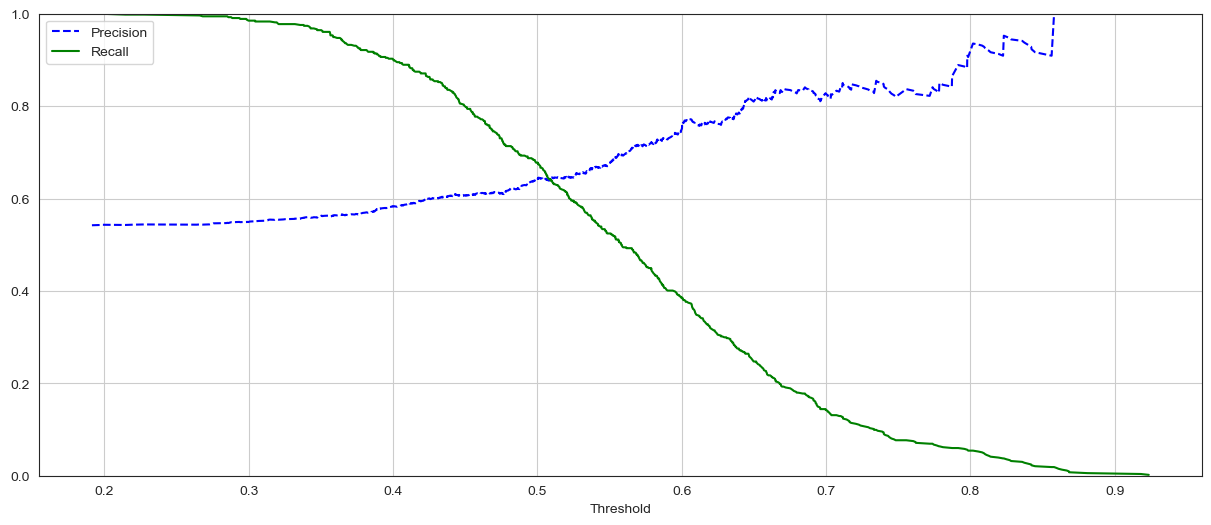

In [86]:
y_proba_lg_top = pipeline_lg_top.predict_proba(X_test_top)
y_proba_win_lg_top = y_proba_lg_top[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_lg_top)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

Precision: 0.6746987951807228
Recall: 0.5243445692883895


<AxesSubplot:>

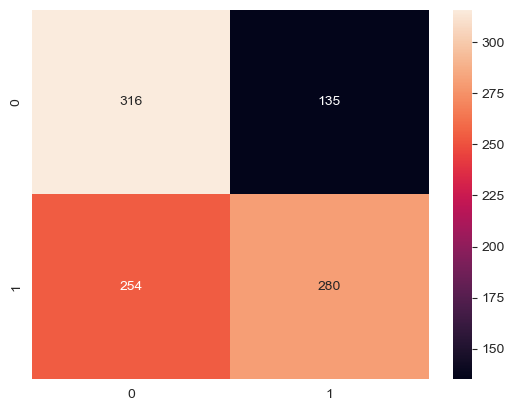

In [87]:
threshold = 0.55

y_pred = np.where(y_proba_win_lg_top >= threshold, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [88]:
score_dict['model'].append('LogisticRegressionFeatureSelected')
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['threshold'].append(threshold)

### SVM

In [63]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_svc_top = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=17))
])

pipeline_svc_top.fit(X_train_top, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['win_home_team',
                                                   'win_visiting_team', 'draw',
                                                   'v_avg_road_goals_for',
                                                   'h_avg_home_goals_for',
                                                   'h_goals_for_pctg',
                                                   'v_avg_road_goals_against',
                                                   'h_avg_home_goals_against',
                                                   'v_goals_for_pctg',
                                                   'h_regulation_win_pctg',
                                                   'v_league_road_sequence',
                                                   'h_goal_differential_pctg',
                                                   'h_l...
                                                   'h_road_goal_differential',
                                                   'v_league_home_sequence',
                                                   'v_goal_differential',
                                                   'v_league_l10_sequence', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'home_team_code',
                                                   'visiting_team_code',
                                                   'h_division_name',
                                                   'h_streak_code',
                                                   'v_division_name',
                                                   'v_streak_code',
                                                   'game_month'])])),
                ('classifier', SVC(probability=True, random_state=17))])

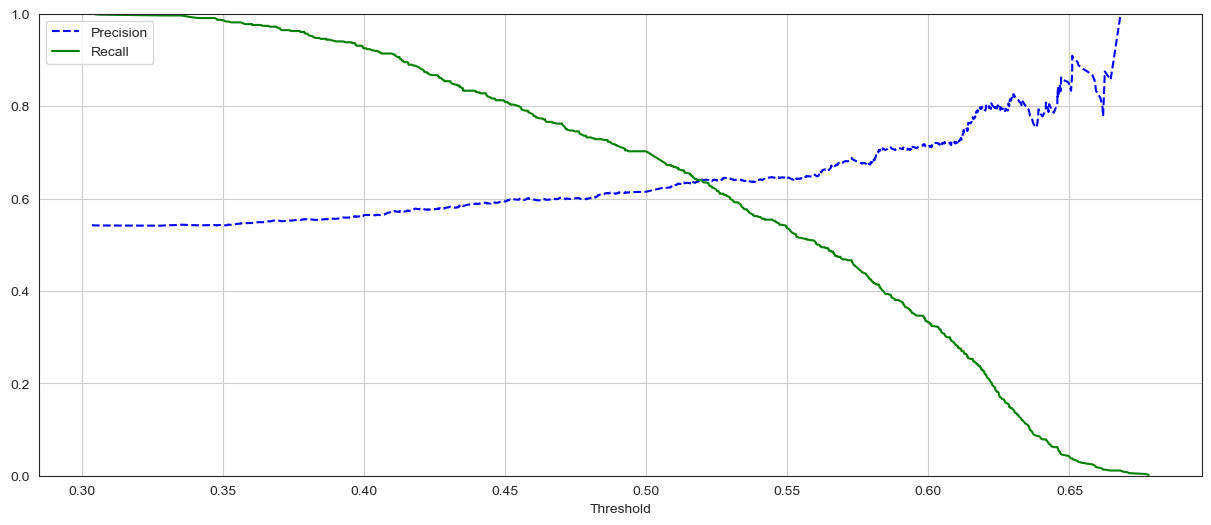

In [89]:
y_proba_svc_top = pipeline_svc_top.predict_proba(X_test)
y_proba_win_svc_top = y_proba_svc_top[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_svc_top)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

Precision: 0.6455981941309256
Recall: 0.5355805243445693


<AxesSubplot:>

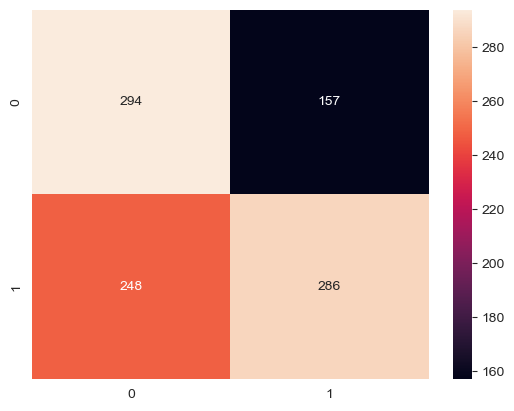

In [90]:
threshold = 0.55

y_pred = np.where(y_proba_win_svc_top >= threshold, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [91]:
score_dict['model'].append('SVCFeatureSelected')
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['threshold'].append(threshold)

### CatBoostClassifier

In [67]:
catboost_cl_top = CatBoostClassifier(
    iterations=10000,
    random_state=17,
    cat_features=categorical_features,
)

catboost_cl_top.fit(X_train_top, y_train, verbose=500)

Learning rate set to 0.004014
0:	learn: 0.6929633	total: 19.7ms	remaining: 3m 17s
500:	learn: 0.6627679	total: 6.43s	remaining: 2m 1s
1000:	learn: 0.6544927	total: 12.7s	remaining: 1m 54s
1500:	learn: 0.6477523	total: 19.1s	remaining: 1m 47s
2000:	learn: 0.6411061	total: 25.4s	remaining: 1m 41s
2500:	learn: 0.6341345	total: 31.9s	remaining: 1m 35s
3000:	learn: 0.6254392	total: 38.4s	remaining: 1m 29s
3500:	learn: 0.6166647	total: 44.9s	remaining: 1m 23s
4000:	learn: 0.6079826	total: 51.4s	remaining: 1m 17s
4500:	learn: 0.5997604	total: 57.9s	remaining: 1m 10s
5000:	learn: 0.5917381	total: 1m 4s	remaining: 1m 4s
5500:	learn: 0.5843719	total: 1m 10s	remaining: 58s
6000:	learn: 0.5769336	total: 1m 17s	remaining: 51.6s
6500:	learn: 0.5698595	total: 1m 24s	remaining: 45.2s
7000:	learn: 0.5630489	total: 1m 31s	remaining: 39s
7500:	learn: 0.5560189	total: 1m 37s	remaining: 32.6s
8000:	learn: 0.5493091	total: 1m 44s	remaining: 26.2s
8500:	learn: 0.5428207	total: 1m 51s	remaining: 19.7s
9000:	l

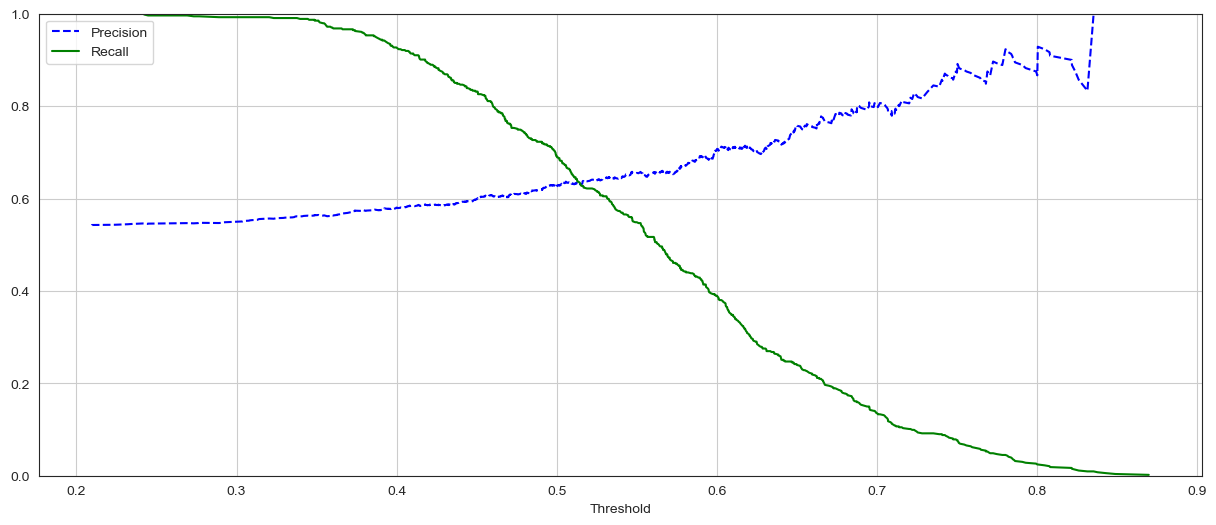

In [92]:
y_proba_catboost_top = catboost_cl_top.predict_proba(X_test_top)
y_proba_win_catboost_top = y_proba_catboost_top[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_win_catboost_top)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.grid()
plt.show()

Precision: 0.6554809843400448
Recall: 0.548689138576779


<AxesSubplot:>

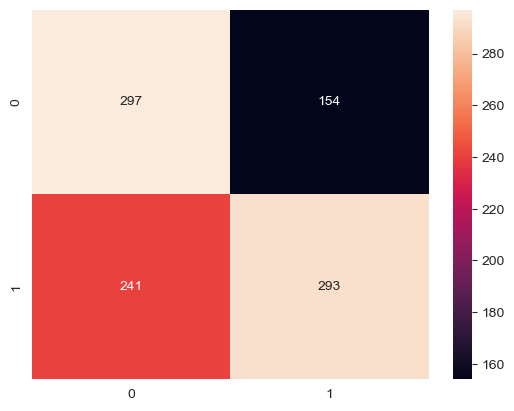

In [93]:
threshold = 0.55

y_pred = np.where(y_proba_win_catboost_top >= threshold, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [94]:
score_dict['model'].append('CatBoostClassifierFeatureSelected')
score_dict['precision'].append(precision)
score_dict['recall'].append(recall)
score_dict['threshold'].append(threshold)

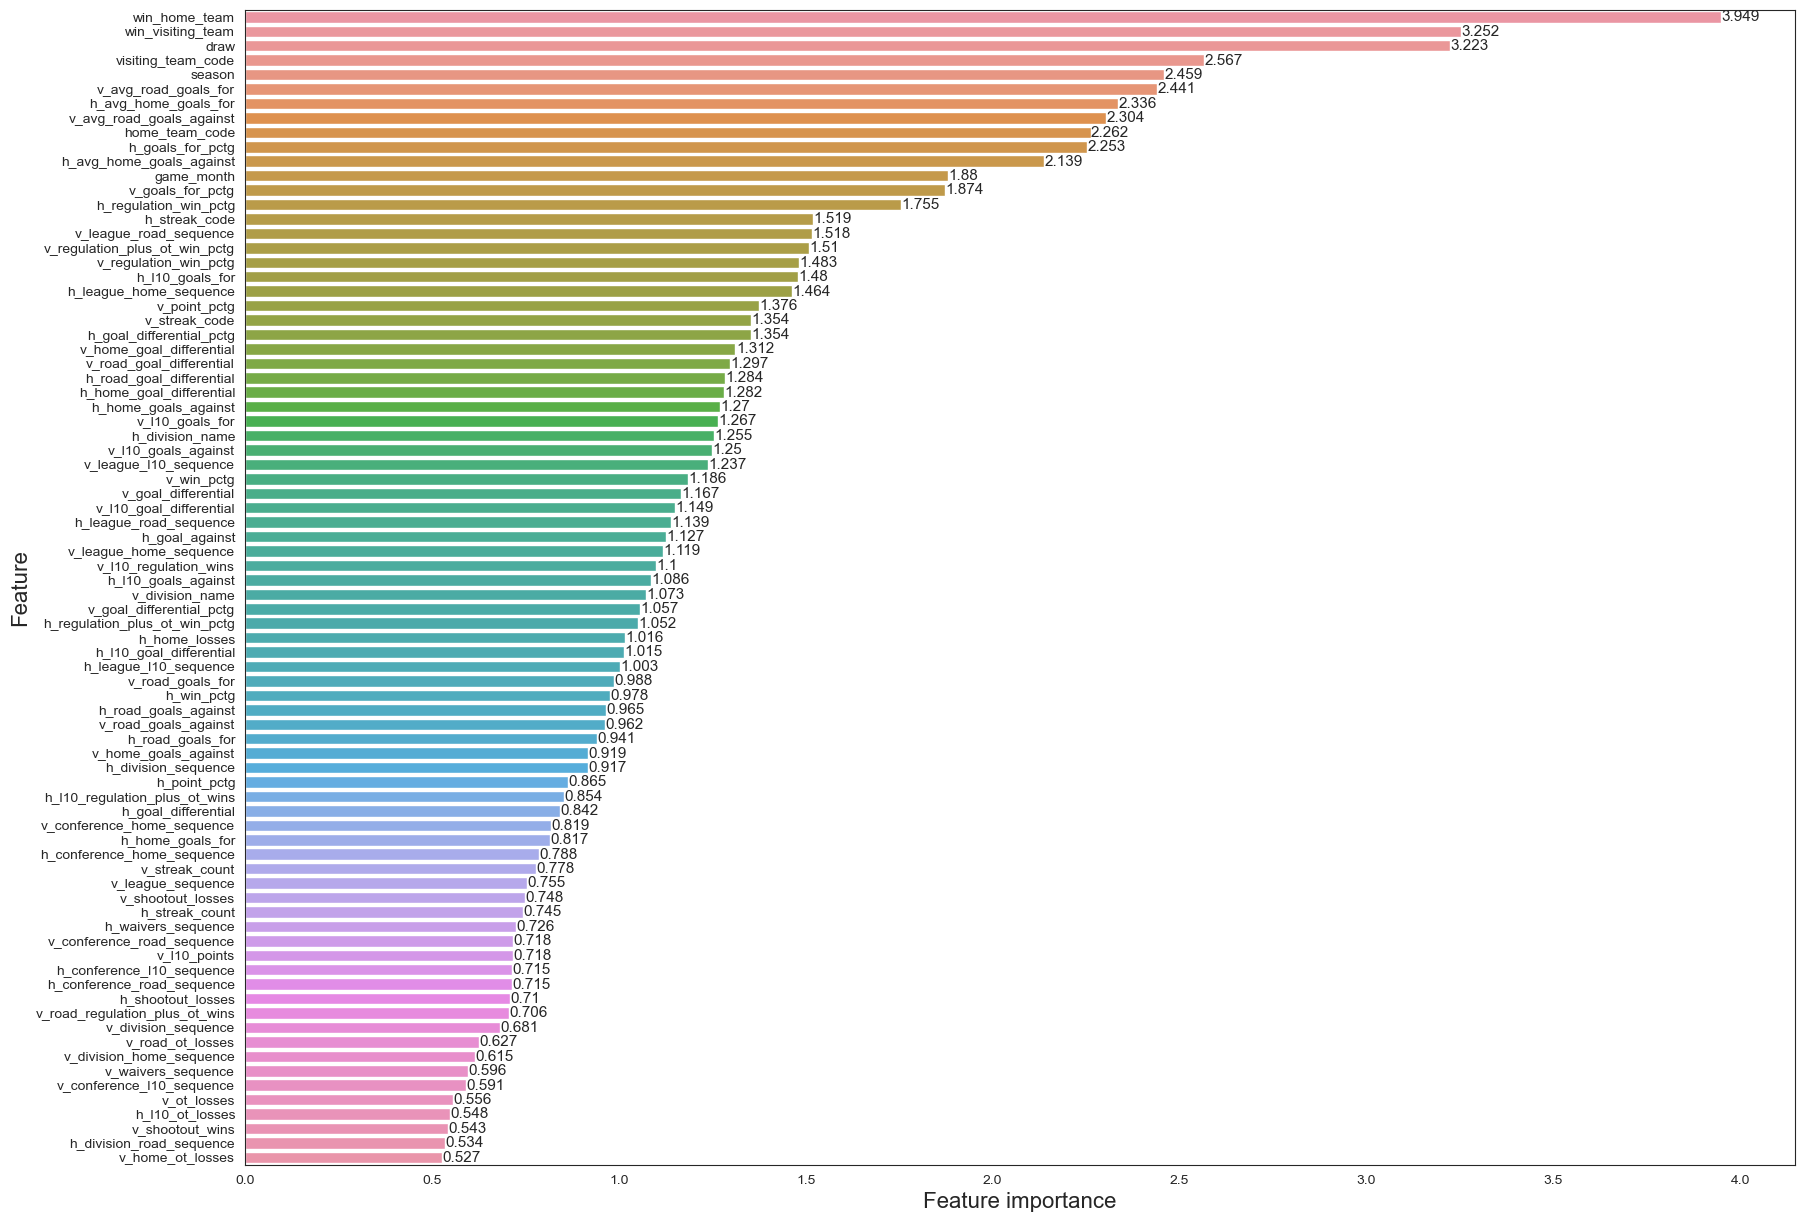

In [95]:
catboost_cl_top_importance = plot_feature_importance(catboost_cl_top, X_train_top, (20, 15))

### Сравним результаты

In [96]:
results = pd.DataFrame(score_dict).drop_duplicates()
results.sort_values(by='precision', ascending=False)

,model,precision,recall,threshold
3,LogisticRegressionFeatureSelected,0.674699,0.524345,0.55
0,LogisticRegression,0.669048,0.526217,0.55
2,CatBoostClassifier,0.657277,0.524345,0.55
5,CatBoostClassifierFeatureSelected,0.655481,0.548689,0.55
1,SVC,0.654545,0.539326,0.55
4,SVCFeatureSelected,0.645598,0.535581,0.55
